In [1]:
import os, sys
import numpy as np
import json
import random
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchvision import datasets, models, transforms
from numpy import linalg as LA
sys.path.append('../environments/')
from sepsis_env import SepsisEnv

In [2]:
env = SepsisEnv()
fg_tuples = env.generate_tuples(group="foreground", n_trajectories=10)
bg_tuples = env.generate_tuples(group="background", n_trajectories=10)
all_tuples = bg_tuples + fg_tuples
random.shuffle(all_tuples)
split = 0.8
train_tuples = all_tuples[:int(split*len(all_tuples))]
test_tuples = all_tuples[int(split*len(all_tuples)):]

In [3]:
class ContrastiveDataset(Dataset):
    def __init__(self, tuples):
        self.tuples = tuples
            
        def construct_pairs(tuples):
            X = []
            y = []
            for t in self.tuples:
                if t[4] == 'background':
                    one_hot_a = [0]*25
                    s = t[0]
                    a = t[1]
                    one_hot_a[a] = 1
                    r = t[3][0]
                    if r == 0:
                        r = 0.00000001
                    
                    blank_s = [0]*46
                    blank_a = [0]
                    s_a = np.hstack((s, a, blank_s, blank_a))
                    X.append(s_a)
                    y.append(r)
                else:
                    one_hot_a = [0]*25
                    s = t[0]
                    a = t[1]
                    one_hot_a[a] = 1
                    r = t[3][0]
                    if r == 0:
                        r = 0.00000001
                    
                    s_a = np.hstack((s, a, s, a))
                    X.append(s_a)
                    y.append(r)
            return X, y
    
        self.X, self.y = construct_pairs(self.tuples)

    def __len__(self):
        return len(self.tuples)

    def __getitem__(self,idx):
        return (self.X[idx], self.y[idx])

In [23]:
class LinearContrastiveNet(nn.Module):
    def __init__(self):
        super(LinearContrastiveNet, self).__init__()
        self.name = "LinearContrastiveNet"
        self.fc1 = nn.Linear(94, 10)
        self.fc2 = nn.Linear(10, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [30]:
class ConvContrastiveNet(nn.Module):
    def __init__(self):
        super(ConvContrastiveNet, self).__init__()
        self.name = "ConvContrastiveNet"
        self.conv1 = self.cnn_apt_1 = nn.Conv1d(1, 10, 5) 
        self.fc1 = nn.Linear(90, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x 

In [31]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

  0%|          | 0/135 [00:00<?, ?it/s]/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 135/135 [00:00<00:00, 4248.37it/s]
/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

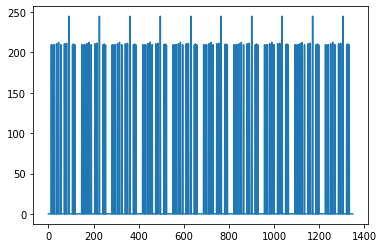

In [32]:
model = ConvContrastiveNet()
train_ds=ContrastiveDataset(train_tuples)
test_ds=ContrastiveDataset(test_tuples)
model.apply(weights_init)
optimizer = SGD(model.parameters(), lr=0.001)
num_epochs = 10
criterion = nn.MSELoss()    
losses = []
for epoch in range(num_epochs):
    for i, (s_a, r) in enumerate(tqdm.tqdm(train_ds)):
        if model.name == "ConvContrastiveNet":
            s_a = np.reshape(s_a, (1, 1, 94))
        s_a = torch.Tensor(s_a)
        r = torch.Tensor([r])
        model.train()
        pred_r = model(s_a)
        train_loss = criterion(pred_r, r)
        losses.append(train_loss.detach().cpu().numpy().item())
iterations = [i for i in range(len(losses))]
sns.lineplot(iterations, losses)

# Interpretability

## Linear Model

In [ ]:
# First 47 elements are shared, second 47 are fg specific
model.fc2.weight

In [ ]:
bg_weights = model.fc2.weight[0][:5]
fg_weights = model.fc2.weight[0][5:]

In [ ]:
# 1 is fg, 0 is bg. This is the contrastive representation. 
sns.heatmap([bg_weights.detach().cpu().numpy(), fg_weights.detach().cpu().numpy()])

## Conv Model

In [36]:
np.squeeze(model.conv1.weight).shape

torch.Size([10, 5])

<AxesSubplot:>

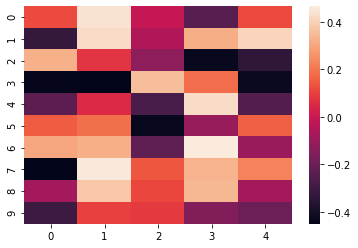

In [37]:
sns.heatmap(np.squeeze(model.conv1.weight.detach().cpu().numpy()))